# Trajectories by simple integration for advected waves and unadvected waves

In [3]:
import numpy as np
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import xsimlab as xs

## Classes

In [225]:
@xs.process
class ProfileP:
    """Compute the evolution of positions and velocities."""

    p_vars = xs.group("p_vars")
    p = xs.variable(dims="p", intent="inout", description="positions of particules", attrs={"units": "m"})#attrs to print the units on graphs
    
    v_vars = xs.group("v_vars")
    v = xs.variable(dims="v", intent="inout", description="velocity of particules", attrs={"units": "m/s"})

    def run_step(self):
        self._delta_p = sum((x for x in self.p_vars))
        self._delta_v = sum((u for u in self.v_vars))
        

    def finalize_step(self):
        self.v += self._delta_v #v(t+dt)
        self.p += self._delta_p #p(t+dt)


In [226]:
def analytical_velocity_advected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*(x-um*t))

@xs.process
class AdvectedWave:
    """Calculate velocity at t and in all positions.
"""
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})

    v = xs.foreign(ProfileP, "v", intent="out")
    p = xs.foreign(ProfileP, "p")

    v_diff = xs.variable(dims="v", intent="out", groups="v_vars")
    
    #INITIALISATION OF VELOCITY
    @xs.runtime(args="sim_start")#this way t is the beginning time of the simulation
    def initialize(self,t):
        self.v = self.um + self.uw*np.cos(self.w*t-self.k*(self.p-self.um*t))
    
    #CALCULATION OF VELOCITY AT t time and position p
    @xs.runtime(args=["step_start","step_delta"])#then t=current step start(date)time (t+dt)
    def run_step(self,t,dt):
        self.v_diff = analytical_velocity_advected(t+dt, self.p + self.v*dt, self.um, self.uw, self.w, self.k)-self.v  # v(x(t+dt),t+dt)-v(x(t),t)
        #self.v_diff = self.um + self.uw*np.cos(self.w*t-self.k*(self.p-self.um*t))-self.v


In [228]:
def analytical_velocity_unadvected(t, x, um, uw, w, k):
    return um + uw*np.cos(w*t-k*x)


@xs.process
class UnadvectedWave:
    """Calculate velocity at t and in all positions.
"""
    um = xs.variable(description="uniform and constant flow amplitude", attrs={"units":"m/s"})
    uw = xs.variable(description="wave amplitude", attrs={"units":"m/s"})
    w = xs.variable(description="wave pulsation", attrs={"units":"s^-1"})
    k = xs.variable(description="wave number", attrs={"units":"m⁻1"})

    v = xs.foreign(ProfileP, "v", intent="out")
    p = xs.foreign(ProfileP, "p")

    v_diff = xs.variable(dims="v", intent="out", groups="v_vars")
    
    @xs.runtime(args="sim_start")
    def initialize(self,t):
        self.v = self.um + self.uw*np.cos(self.w*t-self.k*self.p)
        
    @xs.runtime(args=["step_start", "step_delta"])#then t=current step start (date)time
    def run_step(self,t,dt):
        #self.v_diff = self.um + self.uw*np.cos(self.w*t-self.k*self.p)-self.v
        self.v_diff = analytical_velocity_unadvected(t, self.p + self.v*dt, self.um, self.uw, self.w, self.k) - self.v
        #first step calculate 0, it is not very useful, is that a problem?


In [230]:
@xs.process
class Euler:
    """Calculate positions at t+dt using Euler method.
"""
    p_advected = xs.variable(dims="p", intent="out", groups="p_vars")
    v = xs.foreign(ProfileP,"v")

    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.p_advected = self.v*dt#self.v est la vitesse à l'instant t 

In [231]:
@xs.process
class InitRegular:
    """Initialize `positions` profile with N regular values in a giving an interval."""

    mini = xs.variable(description="minimum for initial position", static=True)
    maxi = xs.variable(description="maximum for initial position", static=True)
    N =xs.variable(description="number of particules", static=True)
    p = xs.foreign(ProfileP, "p", intent="out")
    
      
    def initialize(self):
        self.p = np.linspace(self.mini, self.maxi, self.N)


## Model for advected waves integrated with the Euler method

In [232]:
# CREATE xs.Model
advect_model = xs.Model(
    {
        "profile": ProfileP,
        "init": InitRegular,
        "intmethod": Euler,
        "velocity": AdvectedWave
    }
)


In [233]:
advect_model

<xsimlab.Model (4 processes, 7 inputs)>
init
    mini        [in] minimum for initial position
    maxi        [in] maximum for initial position
    N           [in] number of particules
velocity
    um          [in] uniform and constant flow amplitude
    uw          [in] wave amplitude
    w           [in] wave pulsation
    k           [in] wave number
intmethod
profile

In [281]:
#CREATE SET UP
in_ds_advect = xs.create_setup(model=advect_model, 
                        clocks={'time': np.linspace(0,48*3600, 201),
                                'otime': [0, 21600,43200,64800,86400, 108000,151200,172800 ]}, 
                        master_clock='time',
                        input_vars={'init': {'mini': 0., 'maxi': 200000., 'N':100},#INITIALISATION
                                    'velocity': {'um': 0.1, 'uw': 0.5, 'w':1.4*10**(-4), 'k':6.10**(-5)},
                                    },
                        output_vars={'profile__p' : 'otime','profile__v' : 'otime'})


In [282]:
in_ds_advect

<xarray.Dataset>
Dimensions:       (otime: 8, time: 201)
Coordinates:
  * time          (time) float64 0.0 864.0 1.728e+03 ... 1.719e+05 1.728e+05
  * otime         (otime) int64 0 21600 43200 64800 86400 108000 151200 172800
Data variables:
    init__mini    float64 0.0
    init__maxi    float64 2e+05
    init__N       int64 100
    velocity__um  float64 0.1
    velocity__uw  float64 0.5
    velocity__w   float64 0.00014
    velocity__k   float64 0.0001184

In [283]:
out_ds_advect = in_ds_advect.xsimlab.run(model=advect_model)
out_ds_advect

<xarray.Dataset>
Dimensions:       (otime: 8, p: 100, time: 201, v: 100)
Coordinates:
  * otime         (otime) int64 0 21600 43200 64800 86400 108000 151200 172800
  * time          (time) float64 0.0 864.0 1.728e+03 ... 1.719e+05 1.728e+05
Dimensions without coordinates: p, v
Data variables:
    init__N       int64 100
    init__maxi    float64 2e+05
    init__mini    float64 0.0
    profile__p    (otime, p) float64 0.0 2.02e+03 ... 2.277e+05 2.292e+05
    profile__v    (otime, v) float64 0.6 0.5858 0.5439 ... 0.5204 0.4752 0.4111
    velocity__k   float64 0.0001184
    velocity__um  float64 0.1
    velocity__uw  float64 0.5
    velocity__w   float64 0.00014

### Positions plots

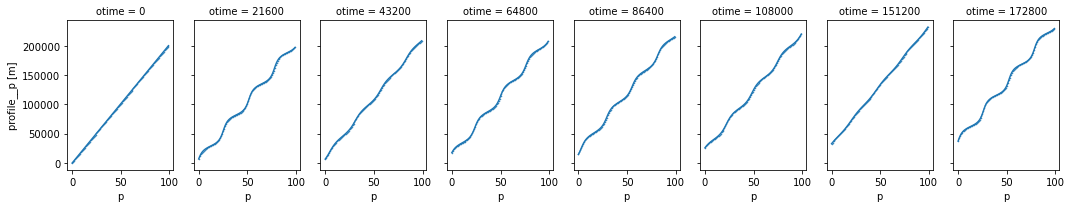

In [284]:
p = out_ds_advect.profile__p
v = out_ds_advect.profile__v
p.plot(col="otime", marker=".", markersize=1, figsize=(15,3));

In [285]:
p = p.assign_coords(p=p.isel(otime=0, drop=True))


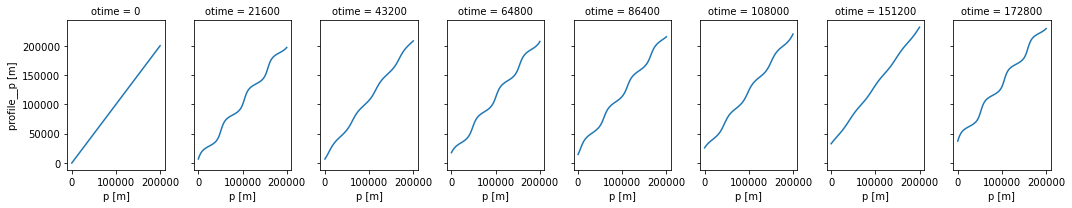

In [286]:
p.plot(col="otime", figsize=(15,3));

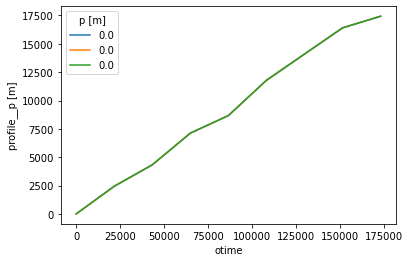

In [268]:
_ = p.sel(p=[0, 1., 2.], method='nearest').plot.line(x='otime')

#### Advancement

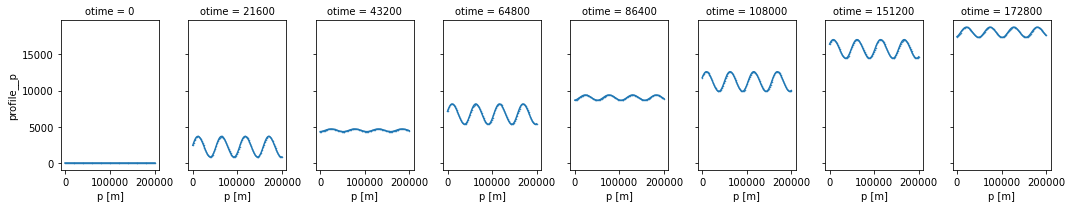

In [269]:
p0 = p.isel(otime=0, drop=True)
adv= p-p0
adv.plot(col="otime", marker=".", markersize=1, figsize=(15,3));

### Velocities plots

In [270]:
v.sel(otime=[0,864], method='nearest')

<xarray.DataArray 'profile__v' (otime: 2, v: 100)>
array([[2.00000000e-01, 1.97152986e-01, 1.88774052e-01, 1.75340298e-01,
        1.57616646e-01, 1.36612285e-01, 1.13523210e-01, 8.96641197e-02,
        6.63935573e-02, 4.50365555e-02, 2.68091882e-02, 1.27493269e-02,
        3.65754421e-03, 5.15288713e-05, 2.13660844e-03, 9.79405789e-03,
        2.25878598e-02, 3.97895314e-02, 6.04196046e-02, 8.33033969e-02,
        1.07137899e-01, 1.30565966e-01, 1.52253599e-01, 1.70965897e-01,
        1.85637376e-01, 1.95432638e-01, 1.99793938e-01, 1.98472942e-01,
        1.91544868e-01, 1.79404203e-01, 1.62742240e-01, 1.42507715e-01,
        1.19852789e-01, 9.60674391e-02, 7.25060105e-02, 5.05100976e-02,
        3.13321540e-02, 1.60641775e-02, 5.57553109e-03, 4.63441270e-04,
        1.01899195e-03, 7.21054991e-03, 1.86855660e-02, 3.47906496e-02,
        5.46087725e-02, 7.70114850e-02, 1.00723170e-01, 1.24393678e-01,
        1.46675203e-01, 1.66299028e-01, 1.82147767e-01, 1.93318988e-01,
        1.99176600e-01, 1.99387067e-01, 1.93938405e-01, 1.83140864e-01,
        1.67609258e-01, 1.48227961e-01, 1.26100550e-01, 1.02486966e-01,
        7.87317732e-02, 5.61875997e-02, 3.61381170e-02, 1.97249485e-02,
        7.88266459e-03, 1.28556847e-03, 3.09300698e-04, 5.00945023e-03,
        1.51183892e-02, 3.00605117e-02, 4.89850089e-02, 7.08143145e-02,
        9.43054614e-02, 1.18120857e-01, 1.40904446e-01, 1.61358924e-01,
        1.78319607e-01, 1.90820748e-01, 1.98150530e-01, 1.99891593e-01,
...
        1.07137899e-01, 1.30565966e-01, 1.52253599e-01, 1.70965897e-01,
        1.85637376e-01, 1.95432638e-01, 1.99793938e-01, 1.98472942e-01,
        1.91544868e-01, 1.79404203e-01, 1.62742240e-01, 1.42507715e-01,
        1.19852789e-01, 9.60674391e-02, 7.25060105e-02, 5.05100976e-02,
        3.13321540e-02, 1.60641775e-02, 5.57553109e-03, 4.63441270e-04,
        1.01899195e-03, 7.21054991e-03, 1.86855660e-02, 3.47906496e-02,
        5.46087725e-02, 7.70114850e-02, 1.00723170e-01, 1.24393678e-01,
        1.46675203e-01, 1.66299028e-01, 1.82147767e-01, 1.93318988e-01,
        1.99176600e-01, 1.99387067e-01, 1.93938405e-01, 1.83140864e-01,
        1.67609258e-01, 1.48227961e-01, 1.26100550e-01, 1.02486966e-01,
        7.87317732e-02, 5.61875997e-02, 3.61381170e-02, 1.97249485e-02,
        7.88266459e-03, 1.28556847e-03, 3.09300698e-04, 5.00945023e-03,
        1.51183892e-02, 3.00605117e-02, 4.89850089e-02, 7.08143145e-02,
        9.43054614e-02, 1.18120857e-01, 1.40904446e-01, 1.61358924e-01,
        1.78319607e-01, 1.90820748e-01, 1.98150530e-01, 1.99891593e-01,
        1.95944799e-01, 1.86534881e-01, 1.72197641e-01, 1.53749447e-01,
        1.32240743e-01, 1.08896243e-01, 8.50451876e-02, 6.20456637e-02,
        4.12072707e-02, 2.37165528e-02, 1.05694364e-02, 2.51452229e-03,
        1.04595037e-05, 3.19983012e-03, 1.19010305e-02, 2.56186117e-02,
        4.35714907e-02, 6.47374253e-02, 8.79112212e-02, 1.11773356e-01]])
Coordinates:
  * otime    (otime) int64 0 0
Dimensions without coordinates: v
Attributes:
    description:  velocity of particules
    units:        m/s

In [271]:
_ds = out_ds_advect
v_a = analytical_velocity_advected(_ds.otime, _ds.profile__p, _ds.velocity__um, _ds.velocity__uw, _ds.velocity__w, _ds.velocity__k)

In [272]:
v_a=v_a.assign_coords(p=np.arange(0,100))

In [273]:
v_a.coords

Coordinates:
  * otime    (otime) int64 0 21600 43200 64800 86400 108000 151200 172800
  * p        (p) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99

In [274]:
_ds=_ds.assign_coords(v=np.arange(0,100)).rename({"v":"p"})

In [275]:
(v_a-_ds.profile__v)

<xarray.DataArray (otime: 8, p: 100)>
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
...
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])
Coordinates:
  * otime    (otime) int64 0 21600 43200 64800 86400 108000 151200 172800
  * p        (p) int64 0 1 2 3 4 5 6 7 8 9 10 ... 90 91 92 93 94 95 96 97 98 99

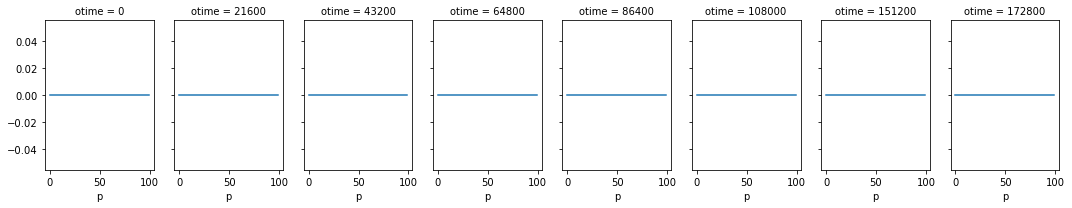

In [276]:
(v_a-_ds.profile__v).plot(col="otime", figsize=(15,3));

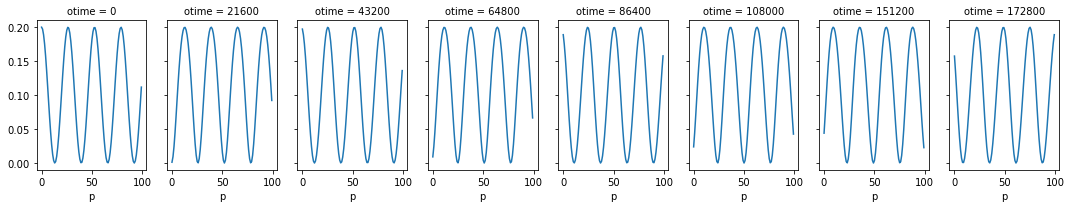

In [277]:
v_a.plot(col="otime", figsize=(15,3));

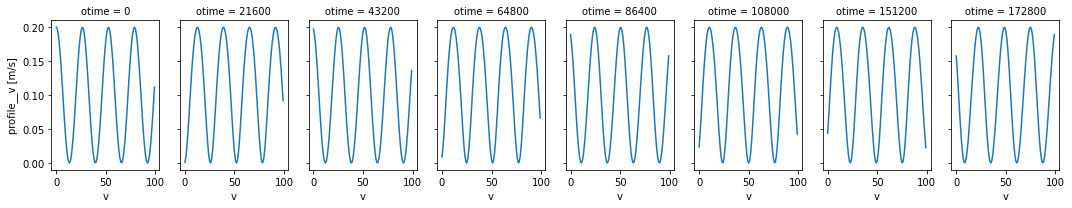

In [278]:
v.plot(col="otime", figsize=(15,3));

## Model for unadvected waves integrated with Euler
### Positions plots

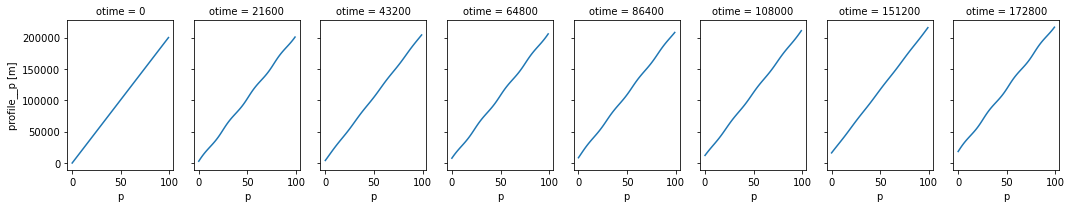

In [279]:
unadvect_model = advect_model.update_processes({"velocity": UnadvectedWave})
out_ds_unadvect = in_ds_advect.xsimlab.run(model=unadvect_model)
out_ds_unadvect.profile__p.plot(col="otime", figsize=(15,3));

### Velocities plots

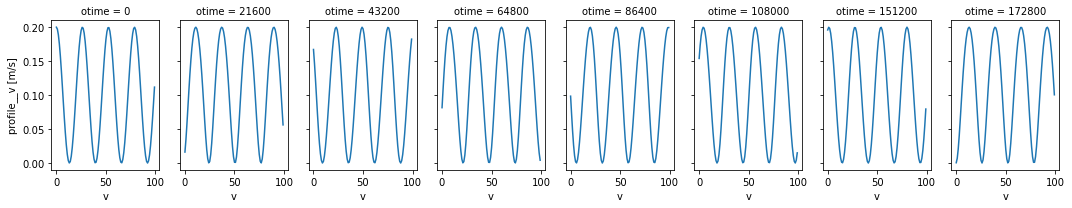

In [280]:
out_ds_unadvect.profile__v.plot(col="otime", figsize=(15,3));